## Autor

Erick Melo Vidal de Oliveira - 190027355

## Introdução

Neste artigo, será abordado uma área chamada Processamento de Linguagem Natural (NLP), que permite que os computadores gerem texto, traduzir línguas, analisar comentários, rotular palavras em frases, dentre outros.

Os modelos de classificação também podem ser utilizados para resolver problemas que, no início, não são obviamente apropriados. Por exemplo, na competição Kaggle [U.S. Patent Phrase to Phrase Matching](https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching/), somos encarregados de comparar duas palavras ou frases curtas, e pontuá-las com base no fato de serem ou não semelhantes, com base na classe de patente em que foram utilizadas, de modo que a pontuação 1 indica que as duas entradas têm um significado idêntico, e 0 significa que têm um significado totalmente diferente.

Acontece que isto pode ser representado como um problema de classificação representando a questão da seguinte forma:

Para o texto "TEXT1: abatement; TEXT2: eliminating process", escolha uma categoria de similaridade dos significados entre "diferente, semelhante ou idêndico"

## Criando Dataset

In [7]:
import os
from pathlib import Path

path = Path('../input/us-patent-phrase-to-phrase-matching')
! pip install -q datasets
!ls {path}

sample_submission.csv  test.csv  train.csv


Normalmente, os documentos com conjunto de dados NLP estão em uma das seguintes formas:

- **Documentos grandes**: Um arquivo de texto por documento, muitas vezes organizado em uma pasta por categoria
- **Documentos pequenos**: Um documento por linha em um [arquivo CSV](https://realpython.com/python-csv/).

Como é possível perceber, neste dataset são utilizados arquivos CSV, então para manipulá-los será utilizada a biblioteca pandas.

In [8]:
import pandas as pd
df = pd.read_csv(path/'train.csv')
df

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00
...,...,...,...,...,...
36468,8e1386cbefd7f245,wood article,wooden article,B44,1.00
36469,42d9e032d1cd3242,wood article,wooden box,B44,0.50
36470,208654ccb9e14fa3,wood article,wooden handle,B44,0.50
36471,756ec035e694722b,wood article,wooden material,B44,0.75


Isto criará uma [DataFrame](https://pandas.pydata.org/docs/user_guide/10min.html), que é uma tabela de colunas nomeadas, um pouco como uma tabela de base de dados. Escrevendo o seu nome é possível visualizar a primeira e última filas, e a contagem de filas do DataFrame.

Cada uma dessas colunas tem o seguinte significado:

 - id - um identificador único para um par de frases
 - anchor - a primeira frase
 - target - a segunda frase
 - context - a [classificação CPC (versão 2021.05)](https://en.wikipedia.org/wiki/Cooperative_Patent_Classification), que indica o assunto no qual a similaridade deve ser pontuada
 - score - a similaridade.
 
Para mais detalhes é possível verificar a [descrição do conjunto de dados](https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching/data).



Uma das características mais úteis do DataFrame é o método `describe()`:

In [9]:
df.describe(include='object')

,id,anchor,target,context
count,36473,36473,36473,36473
unique,36473,733,29340,106
top,37d61fd2272659b1,component composite coating,composition,H01
freq,1,152,24,2186


Podemos ver que nas 36473 linhas, existem 733 âncoras e 106 contextos que aparecem uma única vez. Além disso, é possível notar que a âncora que mais aparece é "component composite coating", com uma frequência de 152 vezes.

Como dito anteriormente, será utilizado o seguiinte padrão para representar a entrada do modelo:
`TEXT1:context; TEXT2: target; ANC1: anchor`, e com o método `head()` será possível visualizar como ficaram as primeiras linhas da entrada.

In [10]:
df['input'] = 'TEXT1: ' + df.context + '; TEXT2: ' + df.target + '; ANC1: ' + df.anchor
df.input.head()

0    TEXT1: A47; TEXT2: abatement of pollution; ANC...
1    TEXT1: A47; TEXT2: act of abating; ANC1: abate...
2    TEXT1: A47; TEXT2: active catalyst; ANC1: abat...
3    TEXT1: A47; TEXT2: eliminating process; ANC1: ...
4    TEXT1: A47; TEXT2: forest region; ANC1: abatement
Name: input, dtype: object

Podemos referir-nos a uma coluna (também conhecida como uma *série*) ou usando uma notação regular do python chamada "dotted", ou acessar ela como um dicionário. Para obter as primeiras filas, utilize `head()`:

Após isso, já é possível criar o dataset da seguinte forma:

In [11]:
from datasets import Dataset,DatasetDict

ds = Dataset.from_pandas(df)
ds

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'score', 'input'],
    num_rows: 36473
})

Porém, não é possível passar os textos diretamente para um modelo, pois um modelo de aprendizagem profunda espera números como inputs, não frases. Então, precisamos de fazer duas coisas:

- *Tokenização*: Dividir cada texto em palavras (ou na realidade, como veremos, em *tokens*)
- *Numericalização*: Converter cada palavra (ou token) em um número.

Os detalhes sobre como isto é feito dependem do modelo utizilado. Portanto, primeiro precisamos de escolher um modelo. Há milhares de modelos disponíveis, mas um ponto de partida razoável para quase todos os problemas de NLP é usar o seguinte modelo:

In [12]:
model_nm = 'microsoft/deberta-v3-small'

### Tokenização e Numericalização

Para esta etapa, será utilizado o`AutoTokenizer` para criar um tokenizer apropriado para o modelo passado como parâmetro

In [13]:
from transformers import AutoModelForSequenceClassification,AutoTokenizer
tokz = AutoTokenizer.from_pretrained(model_nm)

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/578 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Então, para tokenizar os inputs do modelo, será criada a seguinte função:

In [14]:
def tok_func(x): return tokz(x["input"])

Para ser possível rodar a função criada acima para cada linha do dataset em paralelo, será utilizado o método `map()` passando o parâmetro batched como `true`.

In [15]:
tok_ds = ds.map(tok_func, batched=True)

  0%|          | 0/37 [00:00<?, ?ba/s]

Abaixo, é possível visualizar como estão os inputs do modelo seus respectivos tokens gerados

In [16]:
row = tok_ds[0]
row['input'], row['input_ids']

('TEXT1: A47; TEXT2: abatement of pollution; ANC1: abatement',
 [1,
  54453,
  435,
  294,
  336,
  5753,
  346,
  54453,
  445,
  294,
  47284,
  265,
  6435,
  346,
  23702,
  435,
  294,
  47284,
  2])

Agora, é possível preparar as labels. Porém, os Transformers sempre utilizam a coluna nomeada como `labels`, e a coluna do dataset está nomeada como `score`, por isso é necessário renomeá-la. 

In [20]:
tok_ds = tok_ds.rename_columns({'score':'labels'})

## Criando os conjuntos de teste e validação

Ao baixar os arquivos do diretório, é possível verificar que existe um arquivo chamado `test.csv`.

In [21]:
eval_df = pd.read_csv(path/'test.csv')
eval_df.describe()

,id,anchor,target,context
count,36,36,36,36
unique,36,34,36,29
top,4112d61851461f60,el display,inorganic photoconductor drum,G02
freq,1,2,1,3


### Validation set

Para verificar se há um overfiting ou um underfiting no modelo em treinamento é utilizado um conjunto de *validação*. Este é um conjunto de dados que será "escondido" do treinamento. Se utilizar a biblioteca fastai, ela cria automaticamente um conjunto de validação para si se não tiver um, e irá sempre reportar métricas utilizando o conjunto de validação.

O conjunto de validação é *apenas* utilizado para ver como nos estamos indo. Ele *nunca* será utilizado como input para treinar o modelo.

Os Transformers utilizam um `DatasetDict` para realizar os seus conjuntos de treino e validação. Para criar um que contenha 25% dos nossos dados para o conjunto de validação, e 75% para o conjunto de treino, será utilizado o método `train_test_split_split':

In [22]:
dds = tok_ds.train_test_split(0.25, seed=42)
dds

DatasetDict({
    train: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 27354
    })
    test: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9119
    })
})

Como é possível notar acima, o conjunto de validação aqui é chamado "test" e não "validate", por isso é importante ter cuidado.

### Test set

Para criar o conjunto de teste será utilizado a nomenclatura "eval", para evitar confusão com o conjunto de dados "test" criado acima.

In [23]:
eval_df['input'] = 'TEXT1: ' + eval_df.context + '; TEXT2: ' + eval_df.target + '; ANC1: ' + eval_df.anchor
eval_ds = Dataset.from_pandas(eval_df).map(tok_func, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

## Métricas e correlações

Quando estamos treinando um modelo, haverá uma ou mais *métricas* que estamos interessados em maximizar ou minimizar. Estas são as medidas que deverão representar quão bem o nosso modelo funcionará para nós.

Na Kaggle, entretanto, é muito simples saber qual a métrica a ser usada pois a Kaggle dirá. De acordo com a [página de avaliação](https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching/overview/evaluation) desta competição, as submissões são avaliadas no [coeficiente de correlação Pearson](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) entre a pontuação de similaridade prevista e a real. Este coeficiente é normalmente abreviado usando a letra *r*. É a medida mais amplamente utilizada do grau de relacionamento entre duas variáveis.

r pode variar entre `-1`, que significa perfeita correlação inversa, e `+1`, que significa perfeita correlação positiva. 


Para começar a obter essa intuição, será utilizado como exemplo o conjunto de dados [Forest Covertypes](https://scikit-learn.org/stable/datasets/real_world.html#forest-covertypes), que é utilizado para prever o tipo de cobertura de cada mancha florestal nos EUA.


In [24]:
from sklearn.datasets import fetch_covtype
covtype = fetch_covtype(as_frame=True)
covtype = covtype['data'].join(covtype['target']).sample(1000, random_state=52)
covtype.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Cover_Type
466037,3338.0,179.0,13.0,319.0,59.0,3883.0,225.0,247.0,152.0,1844.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
236207,2857.0,8.0,13.0,30.0,4.0,1050.0,205.0,214.0,145.0,2252.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
209448,3211.0,20.0,5.0,30.0,2.0,5192.0,217.0,229.0,150.0,454.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
534914,3054.0,341.0,23.0,600.0,89.0,3421.0,165.0,199.0,168.0,1752.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2
351599,3071.0,27.0,19.0,426.0,87.0,2586.0,209.0,197.0,119.0,2663.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


In [25]:
list(covtype.columns.values)

['Elevation',
 'Aspect',
 'Slope',
 'Horizontal_Distance_To_Hydrology',
 'Vertical_Distance_To_Hydrology',
 'Horizontal_Distance_To_Roadways',
 'Hillshade_9am',
 'Hillshade_Noon',
 'Hillshade_3pm',
 'Horizontal_Distance_To_Fire_Points',
 'Wilderness_Area_0',
 'Wilderness_Area_1',
 'Wilderness_Area_2',
 'Wilderness_Area_3',
 'Soil_Type_0',
 'Soil_Type_1',
 'Soil_Type_2',
 'Soil_Type_3',
 'Soil_Type_4',
 'Soil_Type_5',
 'Soil_Type_6',
 'Soil_Type_7',
 'Soil_Type_8',
 'Soil_Type_9',
 'Soil_Type_10',
 'Soil_Type_11',
 'Soil_Type_12',
 'Soil_Type_13',
 'Soil_Type_14',
 'Soil_Type_15',
 'Soil_Type_16',
 'Soil_Type_17',
 'Soil_Type_18',
 'Soil_Type_19',
 'Soil_Type_20',
 'Soil_Type_21',
 'Soil_Type_22',
 'Soil_Type_23',
 'Soil_Type_24',
 'Soil_Type_25',
 'Soil_Type_26',
 'Soil_Type_27',
 'Soil_Type_28',
 'Soil_Type_29',
 'Soil_Type_30',
 'Soil_Type_31',
 'Soil_Type_32',
 'Soil_Type_33',
 'Soil_Type_34',
 'Soil_Type_35',
 'Soil_Type_36',
 'Soil_Type_37',
 'Soil_Type_38',
 'Soil_Type_39',
 'Cov

É possível ver os coeficientes de correlações para cada combinação do dataset utilizando a função `np.corrcoef`:

In [26]:
import numpy as np, matplotlib.pyplot as plt

np.set_printoptions(precision=2, suppress=True)
np.corrcoef(covtype, rowvar=False)

/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


array([[ 1.  ,  0.04, -0.28, ...,  0.18,  0.27, -0.24],
       [ 0.04,  1.  ,  0.12, ...,  0.01,  0.04,  0.05],
       [-0.28,  0.12,  1.  , ...,  0.05,  0.02,  0.18],
       ...,
       [ 0.18,  0.01,  0.05, ...,  1.  , -0.02,  0.14],
       [ 0.27,  0.04,  0.02, ..., -0.02,  1.  ,  0.2 ],
       [-0.24,  0.05,  0.18, ...,  0.14,  0.2 ,  1.  ]])

Porém, isso não é necessário quando queremos apenas um um coeficiente, por isso foi definida a função que irá fazer tal retorno:

In [27]:
def corr(x,y): return np.corrcoef(x,y)[0][1]

Em seguida, será utilizada a seguinte função para demonstrar alguns exemplos:

In [28]:
def show_corr(df, a, b):
    x,y = df[a],df[b]
    plt.scatter(x,y, alpha=0.5, s=4)
    plt.title(f'{a} vs {b}; r: {corr(x, y):.2f}')

Agora, veremos a correlação entre elevação e tipo de cobertura

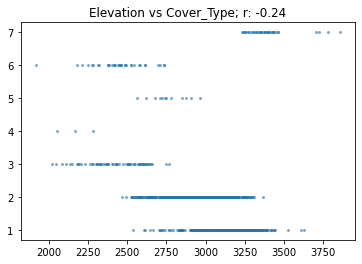

In [29]:
show_corr(covtype, 'Elevation', 'Cover_Type')

Como podemos notar, existe uma correlação de -0,24, o que significa que a relação entre os dois parâmetros comparados é um pouco inversa, contendo algumas variações.

Os Transformers esperam que a métrica seja devolvida como um `dict`, já que dessa forma o trainer sabe qual label utilizar, então está será a função para fazer isso:

In [30]:
def corr_d(eval_pred): return {'pearson': corr(*eval_pred)}

## Trainando o modelo

In [31]:
from transformers import TrainingArguments,Trainer

Toda vez que passamos um dado para o nosso modelo de treinamento ele enviará algumas linhas por vez para a GPU, para que ela possa treiná-las em paralelo, essas linhas são chamadas de batch e o número de linhas seria então o batch size (bs). Normalmente, quanto maior o número do bs, maior será a quantidade que o modelo irá trabalhar com os dados em paralelo, ou seja, mais rápido ele será, porém, se o número for muito grande, ocorrerá uma falta de memória na GPU. Portanto a escolha deste número é feita basicamente por tentativa e erro.

In [32]:
bs = 128
epochs = 4

Para descobrir o learning rate, o FastAi fornece um localizador de learning rate, porem os Transformers não. Por isso, o valor a seguir também foi encontrado por meio de tentativa e erro.

In [33]:
lr = 8e-5

Então, para treinar o modelo será utilizado o trainer, que seria análogo ao learner do FastAi. Mas antes é necessário criar os argumentos que serão passados para ele, que serão basicamente os mesmos para qualquer modelo, utilizando os métodos `TrainingArguments()` e `AutoModelForSequenceClassification()`.

In [34]:
args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
    evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
    num_train_epochs=epochs, weight_decay=0.01, report_to='none')

model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)
trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                  tokenizer=tokz, compute_metrics=corr_d)

Downloading:   0%|          | 0.00/273M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-v3-small were not used when initializing DebertaV2ForSequenceClassification: ['lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'mask_predictions.dense.bias', 'mask_predictions.dense.weight', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from 

Para treinar o modelo, basta utilizar o método `train()` 

In [35]:
trainer.train();

The following columns in the training set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: context, anchor, target, input, id.
/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 27354
  Num Epochs = 4
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 256
  Gradient Accumulation steps = 1
  Total optimization steps = 428
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dime

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.029024,0.794506
2,No log,0.022879,0.820995
3,No log,0.022582,0.828762
4,No log,0.023409,0.828795


The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: context, anchor, target, input, id.
***** Running Evaluation *****
  Num examples = 9119
  Batch size = 512
The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: context, anchor, target, input, id.
***** Running Evaluation *****
  Num examples = 9119
  Batch size = 512
The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: context, anchor, target, input, id.
***** Running Evaluation *****
  Num examples = 9119
  Batch size = 512
The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: context, anchor, target, input, id.
***** Running Evaluation *****
 

Aqui, a coluna que devemos olhar é a da taxa Pearson, que chegou em 82%, o que parece bom. Agora já é possível testar o modelo.

In [36]:
preds = trainer.predict(eval_ds).predictions.astype(float)
preds

The following columns in the test set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: context, anchor, target, input, id.
***** Running Prediction *****
  Num examples = 36
  Batch size = 512


array([[ 0.51],
       [ 0.7 ],
       [ 0.58],
       [ 0.28],
       [-0.06],
       [ 0.49],
       [ 0.47],
       [ 0.  ],
       [ 0.28],
       [ 1.11],
       [ 0.23],
       [ 0.27],
       [ 0.72],
       [ 0.82],
       [ 0.73],
       [ 0.42],
       [ 0.25],
       [ 0.01],
       [ 0.69],
       [ 0.33],
       [ 0.45],
       [ 0.22],
       [ 0.12],
       [ 0.24],
       [ 0.56],
       [-0.03],
       [-0.06],
       [ 0.09],
       [-0.06],
       [ 0.66],
       [ 0.3 ],
       [ 0.06],
       [ 0.69],
       [ 0.54],
       [ 0.44],
       [ 0.22]])

Como é possível notar, algumas predições foram menores que 0 ou maiores que 1, porém este não é um comportamento esperado. Por isso, tais valores foram arredondados para ficarem no limite desejado.

In [37]:
preds = np.clip(preds, 0, 1)
preds

array([[0.51],
       [0.7 ],
       [0.58],
       [0.28],
       [0.  ],
       [0.49],
       [0.47],
       [0.  ],
       [0.28],
       [1.  ],
       [0.23],
       [0.27],
       [0.72],
       [0.82],
       [0.73],
       [0.42],
       [0.25],
       [0.01],
       [0.69],
       [0.33],
       [0.45],
       [0.22],
       [0.12],
       [0.24],
       [0.56],
       [0.  ],
       [0.  ],
       [0.09],
       [0.  ],
       [0.66],
       [0.3 ],
       [0.06],
       [0.69],
       [0.54],
       [0.44],
       [0.22]])

## Deploy

Para realizar o deploy do modelo foram seguidos os passos abaixo

In [38]:
from huggingface_hub import notebook_login
!pip install huggingface_hub

In [39]:
notebook_login()

In [40]:
#pacote para evitar conflitos com arquivos grandes
!sudo apt-get install git-lfs

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.9.2-1).
0 upgraded, 0 newly installed, 0 to remove and 75 not upgraded.


In [41]:
cd outputs/

/kaggle/working/outputs


In [42]:
model.push_to_hub("lesson4")

/opt/conda/lib/python3.7/site-packages/huggingface_hub/hf_api.py:1004: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/ErickMVdO/lesson4 into local empty directory.


Download file pytorch_model.bin:   0%|          | 15.4k/541M [00:00<?, ?B/s]

Download file spm.model:   1%|          | 16.4k/2.35M [00:00<?, ?B/s]

Clean file spm.model:   0%|          | 1.00k/2.35M [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/541M [00:00<?, ?B/s]

Configuration saved in lesson4/config.json
Model weights saved in lesson4/pytorch_model.bin


Upload file pytorch_model.bin:   0%|          | 32.0k/541M [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/ErickMVdO/lesson4
   a23fb9c..da877ac  main -> main



'https://huggingface.co/ErickMVdO/lesson4/commit/da877ac8497e6eb41f3d16dde5fbab12b2893983'

Seguindo este [tutorial](https://huggingface.co/docs/transformers/model_sharing) foi possível fazer o deploy com sucesso. Porém, não encontrei um jeito de fazer ele possuir o comportamento desejado.

O link para a aplicação está disponível [aqui](https://huggingface.co/spaces/ErickMVdO/Lesson4)